In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.interpolate, os
import pickle, itertools
from natsort import natsorted
import mrcfile, glob, time
import scipy.optimize
from matplotlib.lines import Line2D
from collections import OrderedDict

In [2]:
#################################################
# Functions for fitting Fresnel-affected region #
#################################################

def radial_profile(image, center):
    """
    Efficient method to compute an average radial profile for a 2d image. Code is modified from: 
    https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile.
    Note that bins without counts are disregarded during the calculation.
    
    Inputs:
    -------
    image: 2d data array
    center: tuple of (x,y) positions of circle's center
    
    Outputs:
    --------
    rx: radius of each bin present in rprofile
    rprofile: mean radial profile of image
    """
    y, x = np.indices((image.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    rx = np.unique(r.ravel())
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    rprofile = tbin[nr!=0] / nr[nr!=0]
    return rx, rprofile 


def sliding_window(iterable, size):
    """
    Generate an iterator corresponding to the sliding window of dimensions size over iterable. Code is
    from: https://codereview.stackexchange.com/questions/239352/sliding-window-iteration-in-python.
    
    Inputs:
    -------
    iterable: 1d array to iterate over
    size: length of region to select, int
    
    Outputs:
    --------
    g_window: generator object that iterates over values in sliding window
    """
    iterables = itertools.tee(iter(iterable), size)
    window = zip(*(itertools.islice(t, n, None) for n,t in enumerate(iterables)))
    yield from window


def mask_circle(shape,h,k,r):
    """
    Generate a 2d array of input shape, where pixels that lie within the circle of radius r and
    center (h,k) are set to have a value of 1.
    
    Inputs:
    -------
    shape: (x,y) dimensions of 2d array to generate
    h,k: x,y positions of circle's center
    r: radius of circle
    
    Outputs:
    --------
    cmask: 2d array with pixels in specified circle given a value of 1
    """
    xx, yy = np.meshgrid(range(shape[1]), range(shape[0]))
    radii = np.sqrt(np.square(xx - h) + np.square(yy - k))
    cmask = np.zeros(shape)
    cmask[radii<r] = 1
    return cmask


def fit_beam(mimage, x0=None):
    """
    Fit a circle to the illuminated area of mimage.
    
    Inputs:
    -------
    mimage: thresholded beam image, with approximate illuminated area set to 1
    x0: array of initial guess for [h,k,r] parameters
    
    Outputs:
    --------
    results: optimized [h,k,r] parameters
    """

    def objective(params):
        h,k,r = params
        gimage = mask_circle(mimage.shape,h,k,r)
        return -1*np.corrcoef(mimage.flatten(), gimage.flatten())[0,1]
    
    if x0 is None:
        x0 = [mimage.shape[0]/2, mimage.shape[1]/2, 0.42*mimage.shape[1]]
    res = scipy.optimize.minimize(objective, x0, method = 'Nelder-Mead')
    
    return res.x


def predict_fradii(image, h_f, k_f, r_f, s_interval=12, thr_i=7.5, thr_o=10):
    """
    Predict the inner and outer radii of the Fresnel fringe-affected region. Note that
    the radii values are relative to the input center of the circle.
    
    Inputs:
    -------
    image: 2d array of experimental image
    h_f, k_f, r_f: fit parameters for beam circle
    s_interval: sliding window interval for computing moving variance, optional
    thr_i: how many std. dev. above illuminated mean for estimating inner radius
    thr_o: how many std. dev. above unilluminated mean for estimating inner radius
    
    Outputs:
    --------
    r_inner: predicted inner radius of Fresnel region
    r_outer: predicted outer radius of Fresnel region
    """
    
    # compute the average radial profile 
    r_x, r_y = radial_profile(image, (h_f, k_f))

    # compute the moving variance; var_x: radius, var_y: value
    var_x, var_y = list(), list()
    for xi in sliding_window(r_x, s_interval):
        var_x.append(np.mean(np.array(xi)))
    for xi in sliding_window(r_y, s_interval):
        var_y.append(np.var(np.array(xi)))
    var_x, var_y = np.array(var_x), np.array(var_y)

    # estimate outer radius from where variance changes above unilluminated background
    xi = int(r_f + 0.05*r_f)
    b_mu, b_sigma = np.mean(var_y[xi:]), np.std(var_y[xi:])
    r_outer = var_x[np.where((var_y > b_mu + thr_o*b_sigma) & (var_x < 0.9*var_x.max()))[0][-1]] 
    
    # estimate inner radius from where variance rises above illuminated region due to Fringes
    s,e = h_f + 0.45*r_f, h_f + 0.75*r_f # non-suspect illuminated region
    if s < var_x.min(): 
        s = 1.2*var_x.min()
        e = var_x[np.where(var_y==var_y.max())[0]][0] - r_f*0.1
    v_sel = var_y[(var_x>s) & (var_x<e)] # variance of that region
    i_mu, i_sigma = np.mean(v_sel), np.std(v_sel) 
    r_inner = var_x[np.where((var_y > i_mu + thr_i*i_sigma) & (var_x > s))[0][0]]  
    
    return r_inner, r_outer


In [3]:
#######################################################
# For each image, fit left and right sides separately #
#######################################################

fnames = natsorted(glob.glob("/Users/apeck/Desktop/montage/FFI_BeamImg/*mrc"))
b_mask = 100 # threshold value for creating rough initial beam mask
params_l, params_r = OrderedDict(), OrderedDict()

start_time = time.time()
for fi in range(len(fnames)):

    mag = int(fnames[fi].split("EFTEM")[1].split('kx')[0])
    defocus = int(fnames[fi].split("_")[-1].split("defocus")[0])
    vx_size = float(mrcfile.open(fnames[fi]).voxel_size.x)
    tag = (mag,defocus)

    for pi,pd in enumerate([params_l, params_r]):
        if pi == 0:
            data = mrcfile.open(fnames[fi]).data
        else:
            data = np.fliplr(mrcfile.open(fnames[fi]).data) 
    
        if data[:,-1].min() < b_mask:
            # roughly mask the beam area to facilitate fitting
            sel = data[:,int(data.shape[0]/2):]
            msel = np.zeros_like(sel)
            msel[sel>b_mask] = 1

            # fit circle to beam and predict Fresnel radius
            h_f,k_f,r_f = fit_beam(msel)
            r_i, r_o = predict_fradii(sel, h_f, k_f, r_f)
            r_w = np.abs(r_o - r_i) * vx_size

            pd[tag] = np.array([h_f,k_f,r_f,r_i,r_o,r_w])

            print(f"Dataset {tag,pi}: predicted Fresnel region is {r_w} Angstroms")

        else:
            print(f"Dataset {tag,pi}: beam not positioned correctly for analysis on this side")
    
print(f"elapsed time is {(time.time()-start_time)/60.0:.2f} minutes")

Dataset ((42, 0), 0): predicted Fresnel region is 447.823974609375 Angstroms
Dataset ((42, 0), 1): predicted Fresnel region is 256.2069854736328 Angstroms
Dataset ((42, 2), 0): predicted Fresnel region is 409.0699768066406 Angstroms
Dataset ((42, 2), 1): predicted Fresnel region is 475.81297302246094 Angstroms
Dataset ((42, 4), 0): predicted Fresnel region is 241.135986328125 Angstroms
Dataset ((42, 4), 1): predicted Fresnel region is 426.2939758300781 Angstroms
Dataset ((42, -2), 0): predicted Fresnel region is 508.10797119140625 Angstroms
Dataset ((42, -2), 1): predicted Fresnel region is 273.4309844970703 Angstroms
Dataset ((42, -4), 0): predicted Fresnel region is 529.6379699707031 Angstroms
Dataset ((42, -4), 1): predicted Fresnel region is 150.70999145507812 Angstroms
Dataset ((81, 0), 0): predicted Fresnel region is 201.99598860740662 Angstroms
Dataset ((81, 0), 1): predicted Fresnel region is 152.89199137687683 Angstroms
Dataset ((81, 1), 0): predicted Fresnel region is 141.731

/Users/apeck/Desktop/montage/FFI_BeamImg/EFTEM42kx_0defocus.mrc (42, 0)
/Users/apeck/Desktop/montage/FFI_BeamImg/EFTEM42kx_+4defocus.mrc (42, 4)
/Users/apeck/Desktop/montage/FFI_BeamImg/EFTEM42kx_-4defocus.mrc (42, -4)
/Users/apeck/Desktop/montage/FFI_BeamImg/EFTEM81kx_+1defocus.mrc (81, 1)
/Users/apeck/Desktop/montage/FFI_BeamImg/EFTEM81kx_-1defocus.mrc (81, -1)


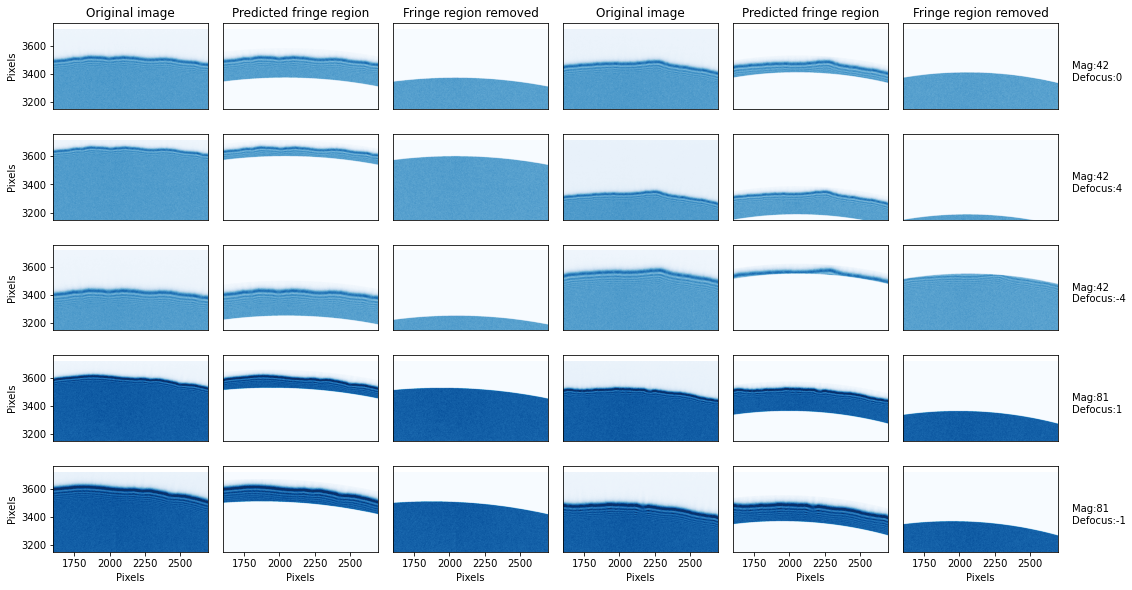

In [39]:
##############################################
# Ploting a selection of representative fits #
##############################################

f, axes = plt.subplots(5,6,figsize=(18,10), sharex=True, sharey=True)
fi_list = [0,2,4,6,8]
vmax = 900

for i in range(30):
    plt.subplot(5,6,i+1)
    col,row,hrow, = i%6,int(i/6),int(i/3)%2
    
    num = fi_list[row]
    lkey,rkey = list(params_l.keys())[num], list(params_r.keys())[num]
    assert lkey == rkey
    
    defocus = int(fnames[num].split("_")[-1].split("defocus")[0])
    mag = int(fnames[num].split("EFTEM")[1].split('kx')[0])
    
    if hrow == 0:
        data = mrcfile.open(fnames[num]).data
        h_f,k_f,r_f,r_i,r_o,r_w = params_l[lkey]
    else:
        data = np.fliplr(mrcfile.open(fnames[num]).data)
        h_f,k_f,r_f,r_i,r_o,r_w = params_r[rkey]
    sel = data[:,int(data.shape[0]/2):]
    if col==0 and hrow==0: print(fnames[num],rkey)

    f_inner = mask_circle(sel.shape,h_f,k_f,r_i)
    f_outer = mask_circle(sel.shape,h_f,k_f,r_o)
    f_comb = f_outer + f_inner
    f_comb[f_comb!=1] = 0
    
    if col==0 or col==3: 
        plt.imshow(sel.T, cmap='Blues', vmax=vmax)
        
    if col==1 or col==4: 
        xd = sel.copy()
        xd[f_comb!=1] = 0
        plt.imshow(xd.T, cmap='Blues', vmin=0, vmax=vmax)

    if col==2 or col==5:
        xd = sel.copy()
        xd[f_inner!=1] = 0
        plt.imshow(xd.T, cmap='Blues', vmin=0, vmax=vmax)

    plt.ylim(3150,3760)
    plt.xlim(1600,2700)

    if (row==0) and (col==0 or col==3): plt.title("Original image")
    if (row==0) and (col==1 or col==4): plt.title("Predicted fringe region")
    if (row==0) and (col==2 or col==5): plt.title("Fringe region removed")

    if col!=0: plt.yticks([])
    else: plt.ylabel("Pixels")
    if row!=4: plt.xticks([])
    else: plt.xlabel("Pixels")
        
    if col==5:
        plt.text(2800,3350, f"Mag:{mag}\nDefocus:{defocus}")
        
f.subplots_adjust(wspace=0.1,hspace=0.1)

f.savefig("/Users/apeck/Desktop/temp/ffit_examples.png", dpi=300, bbox_inches='tight')

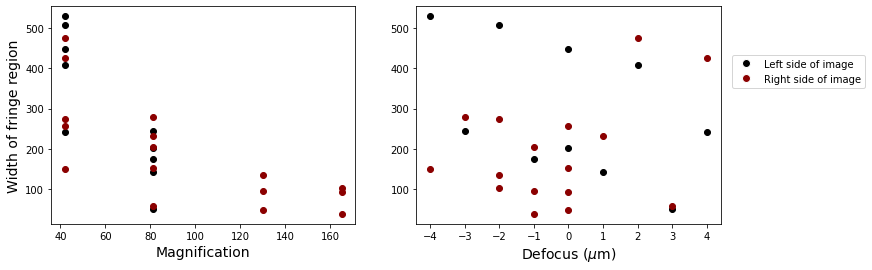

In [76]:
####################################################
# Examining dependence of width on defocus and mag #
####################################################

f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for key in params_l.keys():
    ax1.scatter(key[0],params_l[key][-1], c='black')
for key in params_r.keys():
    ax1.scatter(key[0],params_r[key][-1], c='darkred')
    
for key in params_l.keys():
    ax2.scatter(key[1],params_l[key][-1], c='black')
for key in params_r.keys():
    ax2.scatter(key[1],params_r[key][-1], c='darkred')

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=8)]
ax2.legend(custom_lines, ['Left side of image','Right side of image'],
           bbox_to_anchor=(1.02,0.8))
    
ax1.set_xlabel("Magnification", fontsize=14)
ax2.set_xlabel("Defocus ($\mu$m)", fontsize=14)
ax1.set_ylabel("Width of fringe region", fontsize=14)

f.savefig("/Users/apeck/Desktop/temp/fwidth_vs_magdef.png", dpi=300, bbox_inches='tight')

In [ ]:
###############################################
# Plot showing method behind estimating width #
###############################################

fi = 6
data = np.fliplr(mrcfile.open(fnames[fi]).data)
    
if data[:,-1].min() < b_mask:
    # roughly mask the beam area to facilitate fitting
    sel = data[:,int(data.shape[0]/2):]
    msel = np.zeros_like(sel)
    msel[sel>b_mask] = 1

    # fit circle to beam and predict Fresnel radius
    h_f,k_f,r_f = fit_beam(msel)
    
else:
    print("Problematic image")
    
r_x, r_y = radial_profile(sel, (h_f, k_f))
s_interval = 12

# compute the moving variance; var_x: radius, var_y: value
var_x, var_y = list(), list()
for xi in sliding_window(r_x, s_interval):
    var_x.append(np.mean(np.array(xi)))
for xi in sliding_window(r_y, s_interval):
    var_y.append(np.var(np.array(xi)))
var_x, var_y = np.array(var_x), np.array(var_y)

# predicting outer radius of fringe region
s_interval, thr_i, thr_o = 12, 7.5, 10
xi = int(r_f + 0.05*r_f)
b_mu, b_sigma = np.mean(var_y[xi:]), np.std(var_y[xi:])
r_o = var_x[np.where((var_y > b_mu + thr_o*b_sigma) & (var_x < 0.9*var_x.max()))[0][-1]] 

# predicting inner radius of fringe region
s,e = h_f + 0.45*r_f, h_f + 0.75*r_f # non-suspect illuminated region
if s < var_x.min(): 
    s = 1.2*var_x.min()
    e = var_x[np.where(var_y==var_y.max())[0]][0] - r_f*0.1
v_sel = var_y[(var_x>s) & (var_x<e)] # variance of that region
i_mu, i_sigma = np.mean(v_sel), np.std(v_sel) 
r_i = var_x[np.where((var_y > i_mu + thr_i*i_sigma) & (var_x > s))[0][0]]  

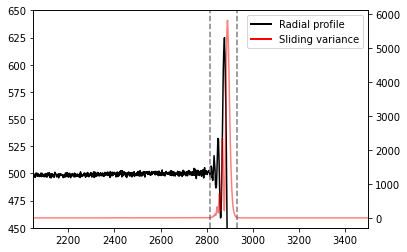

In [58]:
f, ax1 = plt.subplots()

ax1.plot(r_x,r_y, c='black', label='Radial profile')
ax2 = ax1.twinx()  
ax2.plot(var_x,var_y, c='red', label='\nVariance\n(sliding window)', alpha=0.5)

xmin,xmax = h_f + 0.5*r_f, h_f + 0.75*r_f
for ax in [ax1, ax2]:
    ax.set_xlim(xmin,3500)
    
ax1.set_ylim(450,650)
#ax2.set_ylim(0,100)

ax1.plot([r_i,r_i],[450,650], c='grey', linestyle='dashed')
ax1.plot([r_o,r_o],[450,650], c='grey', linestyle='dashed')

custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2)]
ax2.legend(custom_lines, ['Radial profile','Sliding variance'])

Text(0.5, 1.0, 'Difference')

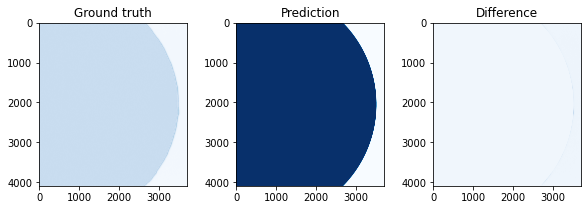

In [34]:
##############################################
# Plot showing predicting of circle beam fit #
##############################################

f_msel = mask_circle(msel.shape,h_f,k_f,r_f)

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,3))

ax1.imshow(sel, cmap='Blues')
ax2.imshow(f_msel, cmap='Blues')
xd = sel.copy()
xd[f_msel==1]=0
ax3.imshow(xd, cmap='Blues')

ax1.set_title("Ground truth")
ax2.set_title("Prediction")
ax3.set_title("Difference")